Loaded T2_2000-03.nc
Loaded SNOWNC_2000-03.nc
Loaded RAINNC_2000-03.nc
Loaded HAILNC_2000-03.nc
Loaded GRAUPELNC_2000-03.nc


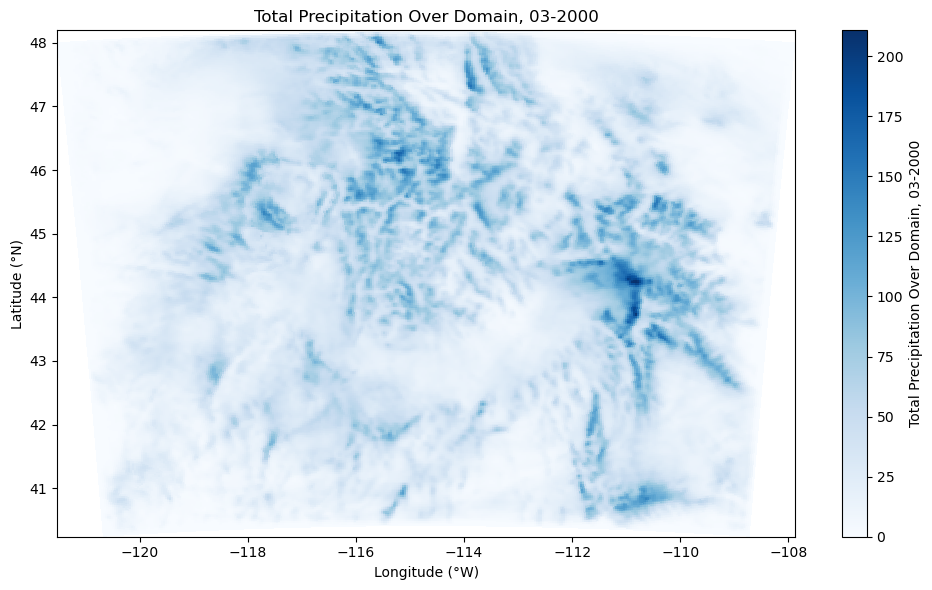

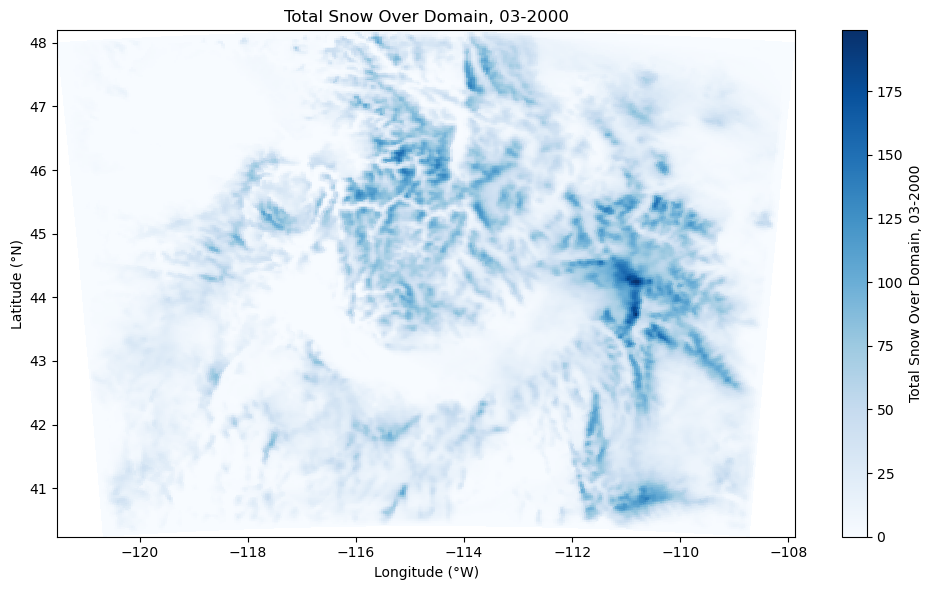

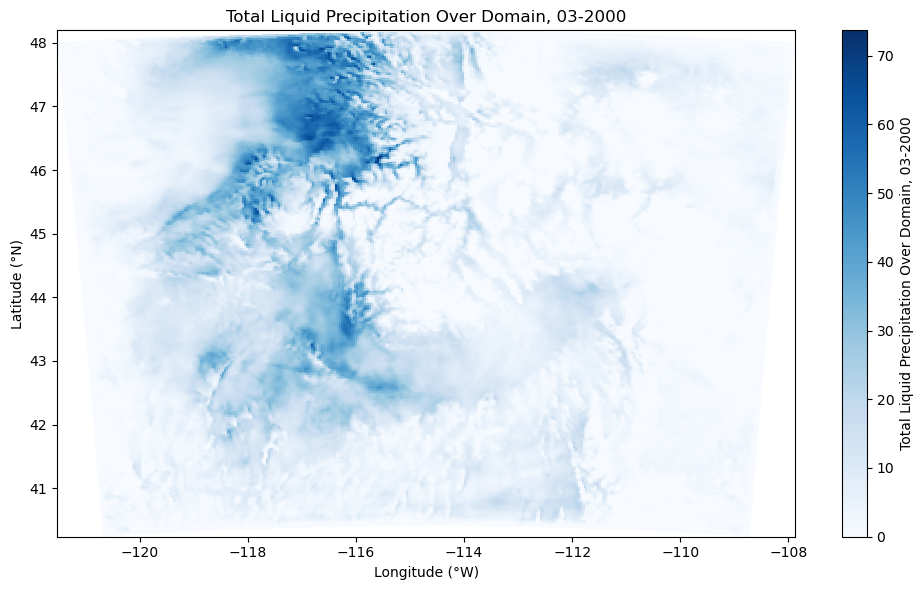

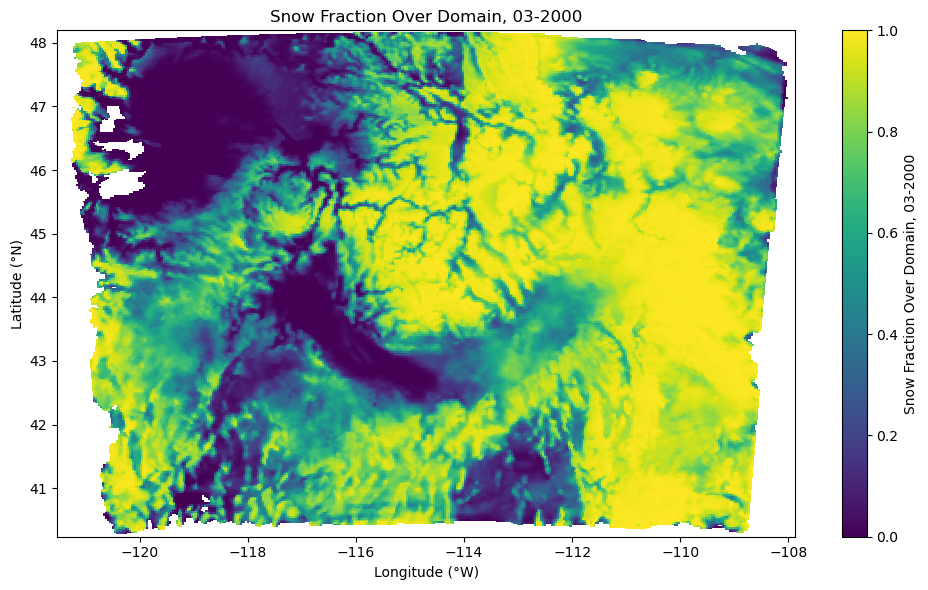

In [17]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import cartopy.crs as ccrs
import geopandas as gpd

# === CONFIGURATION ===
d01_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d01/"
d02_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02"
current_plot_file = d01_dir # update as needed to desired dataset
month = "03"
year = "2000"
target_location = "Domain"
epsilon = 1e-6  # to prevent division by zero
shapefile_path = "cb_2022_us_state_20m.shp"

# === FUNCTION TO LOAD A VARIABLE ===
def load_wrf_var(var_name, current_plot_file, year, month):
    filename = f"{var_name}_{year}-{month}.nc"
    path = os.path.join(current_plot_file, filename)
    try:
        ds = xr.open_dataset(path)
        print(f"Loaded {filename}")
        return ds
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None

# === LOAD REQUIRED DATASETS ===
t2 = load_wrf_var("T2", current_plot_file, year, month)
lats = t2['XLAT'][0, :, :]
lons = t2['XLONG'][0, :, :]
snownc = load_wrf_var("SNOWNC", current_plot_file, year, month)
rainnc = load_wrf_var("RAINNC", current_plot_file, year, month)
hailnc = load_wrf_var("HAILNC", current_plot_file, year, month)
graupelnc = load_wrf_var("GRAUPELNC", current_plot_file, year, month)

# === CORRECTED RAINNC ACCOUNTING FOR ROLLOVER RESET ===
def fix_accum_reset(rainnc, threshold=100.0):
    diff = rainnc.diff(dim="Time", label="upper")
    corrected_diff = xr.where(diff < 0, diff + threshold, diff)
    corrected_accum = corrected_diff.sum(dim="Time")
    return corrected_accum

# === APPLY TO FULL SPATIAL GRID ===
precipitation_total = fix_accum_reset(rainnc['RAINNC'])

# === EXTRACT AGGREGATE TOTAL FOR TARGET LOCATION ===
temp_series = t2['T2'].mean(dim=["south_north", "west_east"]) - 273.15  # K to °C -- confirm if mean is the correct metric
snow_total = snownc['SNOWNC'].diff(dim="Time").clip(min=0).sum(dim="Time")
hail_total = hailnc['HAILNC'].diff(dim="Time").clip(min=0).sum(dim="Time")
graupel_total = graupelnc['GRAUPELNC'].diff(dim="Time").clip(min=0).sum(dim="Time")
time = t2['XTIME']
time_trimmed = time.isel(Time=slice(1, None))
liquid_total = precipitation_total - snow_total - hail_total - graupel_total

# === CALCULATE FRACTIONS WITH MASKING ===
valid_mask = precipitation_total >= 1.0

# Mask snow and precip where total precip is too low
masked_snow_total = snow_total.where(valid_mask)
masked_precip_total = precipitation_total.where(valid_mask)
masked_liquid_total = liquid_total.where(valid_mask)

# Compute fractions only where valid
total_snow = masked_snow_total.sum(dim=["south_north", "west_east"])
total_precip = masked_precip_total.sum(dim=["south_north", "west_east"])
snow_fraction = total_snow / (total_precip + epsilon)
liquid_fraction = masked_liquid_total / (masked_precip_total + epsilon)

# === PLOT TOTAL PRECIPITATION ===
precip_total_map = precipitation_total
plot_with_state_outline(
    lons,
    lats,
    precipitation_total,
    f"Total Precipitation Over {target_location}, {month}-{year}",
    cmap="Blues",
)

# === PLOT TOTAL SNOW ===
snow_total_map = snow_total
plot_with_state_outline(
    lons,
    lats,
    snow_total_map,
    f"Total Snow Over {target_location}, {month}-{year}",
    cmap="Blues",
)

# === PLOT TOTAL LIQUID ===
liquid_total_map = liquid_total
plot_with_state_outline(
    lons,
    lats,
    liquid_total_map,
    f"Total Liquid Precipitation Over {target_location}, {month}-{year}",
    cmap="Blues",
)

# === PLOT TOTAL SNOW FRACTION ===
snow_fraction_map = snow_total / (precipitation_total + epsilon)
masked_snow_fraction = snow_fraction_map.where(valid_mask)
plot_with_state_outline(
    lons,
    lats,
    masked_snow_fraction,
    f"Snow Fraction Over {target_location}, {month}-{year}",
)